# Detecting COVID-19 with Chest X Ray using PyTorch

Image classification of Chest X Rays in one of three classes: Normal, Viral Pneumonia, COVID-19

Notebook created for the guided project [Detecting COVID-19 with Chest X Ray using PyTorch](https://www.coursera.org/projects/covid-19-detection-x-ray) on Coursera

Dataset from [COVID-19 Radiography Dataset](https://www.kaggle.com/tawsifurrahman/covid19-radiography-database) on Kaggle

# Importing Libraries

In [1]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.5.1


# Preparing Training and Test Sets

In [2]:
class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19 Radiography Database'
source_dirs = ['NORMAL', 'Viral Pneumonia', 'COVID-19']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'test'))

    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, 30)
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

# Creating Custom Dataset

In [38]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [39]:
train_transform = torchvision.transforms.Compose([ 
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
])
test_transform = torchvision.transforms.Compose([ 
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                    [0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [40]:
train_dirs = {
    'normal': 'COVID-19 Radiography Database/normal',
    'viral': 'COVID-19 Radiography Database/viral',
    'covid': 'COVID-19 Radiography Database/covid'
}
train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1311 normal examples
Found 1315 viral examples
Found 189 covid examples


In [41]:
test_dirs = {
    'normal': 'COVID-19 Radiography Database/test/normal',
    'viral': 'COVID-19 Radiography Database/test/viral',
    'covid': 'COVID-19 Radiography Database/test/covid'
}
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [42]:
batch_size = 6
dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle= True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle= True)
print(len(dl_train))
print(len(dl_test))

470
15


# Data Visualization

In [45]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(8,4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i+1, xticks=[], yticks=[])
        image = image.numpy().transpose((1,2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        
        col = 'green' if preds[i] ==labels[i] else 'red'
        
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()
        

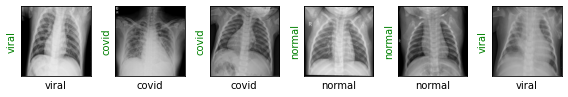

In [46]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

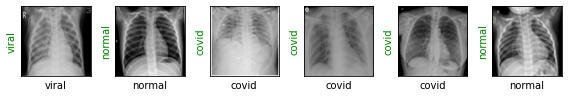

In [47]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the Model

In [48]:
resnet18 = torchvision.models.resnet18(pretrained=True)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [49]:
resnet18.fc =torch.nn.Linear(in_features=512, out_features=3)
loss_fn=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [50]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    output = resnet18(images)
    _, preds = torch.max(output, 1)
    show_images(images, labels, preds)

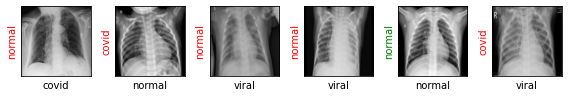

In [51]:
show_preds()

# Training the Model

In [55]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e+1}/{epochs}')
        print('='*20)
        
        train_loss = 0
        val_loss = 0
        
        resnet18.train()
        
        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            output= resnet18(images)
            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()
            train_loss+= loss.item()
            if train_step % 20== 0:
                print('Evaluating at step', train_step)
                acc = 0
                resnet18.eval()
                
                for val_step, (images, labels) in enumerate(dl_test):
                        output= resnet18(images)
                        loss = loss_fn(output, labels)
                        val_loss += loss.item()
                        
                        _, preds = torch.max(output, 1)
                        acc+= sum((preds == labels).numpy())
                val_loss /=  (val_step + 1)
                acc = acc / len(test_dataset)
                print(f'Val loss: {val_loss:.4f}, Acc: {acc:.4f}')
                show_preds()
                
                resnet18.train()
                if acc> 0.95:
                    print('Performance condition satisfied')
                    return 
            train_loss /+ (train_step + 1)
            print(f'Training loss: {train_loss:.4f}')

Starting training..
Starting epoch 1/1
Evaluating at step 0
Val loss: 1.2241, Acc: 0.3222


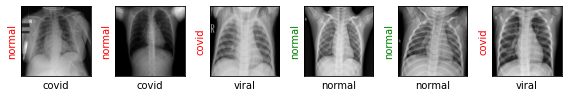

Training loss: 1.4307
Training loss: 2.4516
Training loss: 3.4168
Training loss: 4.7149
Training loss: 5.6097
Training loss: 7.1127
Training loss: 7.7723
Training loss: 8.5504
Training loss: 9.0866
Training loss: 9.8129
Training loss: 10.5463
Training loss: 11.0745
Training loss: 11.9490
Training loss: 12.5891
Training loss: 12.9853
Training loss: 13.4832
Training loss: 14.1517
Training loss: 14.4717
Training loss: 14.7292
Training loss: 15.3600
Evaluating at step 20
Val loss: 0.7252, Acc: 0.7667


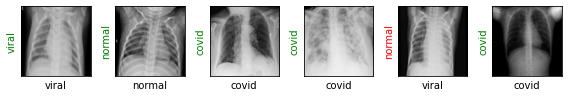

Training loss: 15.7265
Training loss: 16.1660
Training loss: 16.5874
Training loss: 17.3415
Training loss: 17.6405
Training loss: 17.9651
Training loss: 18.8507
Training loss: 19.1976
Training loss: 20.2411
Training loss: 20.7185
Training loss: 21.2917
Training loss: 21.6699
Training loss: 22.2244
Training loss: 22.9902
Training loss: 23.3309
Training loss: 23.8275
Training loss: 24.0599
Training loss: 24.3146
Training loss: 24.9011
Training loss: 25.2923
Evaluating at step 40
Val loss: 0.4022, Acc: 0.9333


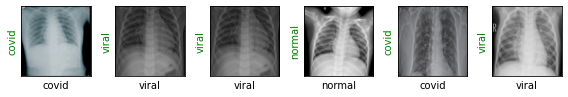

Training loss: 25.5452
Training loss: 25.7046
Training loss: 26.2221
Training loss: 26.4931
Training loss: 26.9238
Training loss: 27.7017
Training loss: 27.8982
Training loss: 28.0813
Training loss: 28.1963
Training loss: 28.5105
Training loss: 28.9339
Training loss: 29.4363
Training loss: 30.1887
Training loss: 30.2646
Training loss: 30.6888
Training loss: 31.2633
Training loss: 31.4289
Training loss: 31.6799
Training loss: 31.8155
Training loss: 32.0833
Evaluating at step 60
Val loss: 0.3198, Acc: 0.8889


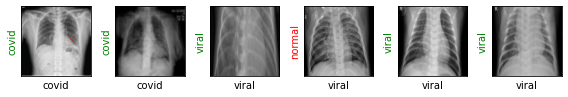

Training loss: 32.1521
Training loss: 32.2991
Training loss: 32.7348
Training loss: 32.8002
Training loss: 32.8886
Training loss: 33.1104
Training loss: 33.3044
Training loss: 33.3864
Training loss: 33.7353
Training loss: 34.0498
Training loss: 34.2127
Training loss: 34.4214
Training loss: 34.5187
Training loss: 34.5951
Training loss: 34.9661
Training loss: 35.0632
Training loss: 35.4644
Training loss: 35.9468
Training loss: 36.3557
Training loss: 36.5979
Evaluating at step 80
Val loss: 0.2354, Acc: 0.9222


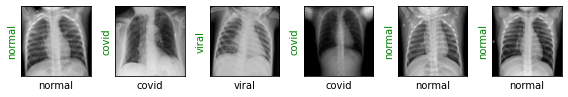

Training loss: 36.8133
Training loss: 38.0707
Training loss: 38.1576
Training loss: 38.4363
Training loss: 38.4883
Training loss: 38.5920
Training loss: 39.6109
Training loss: 39.7267
Training loss: 39.9417
Training loss: 40.2052
Training loss: 40.3689
Training loss: 40.3891
Training loss: 40.5315
Training loss: 40.6679
Training loss: 40.8862
Training loss: 40.9519
Training loss: 41.0263
Training loss: 41.0658
Training loss: 41.2567
Training loss: 41.5535
Evaluating at step 100
Val loss: 0.1104, Acc: 0.9667


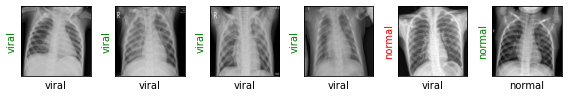

Performance condition satisfied


In [56]:
train(epochs=1)

# Final Results

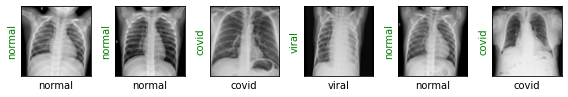

In [57]:
show_preds()